In [ ]:
# Stage 1: Convert PDF to JSON using Docling VLM pipeline via LM Studio
from Functions.utils_logging import setup_basic_logging
setup_basic_logging()

from Functions.pdf_to_json import convert_pdf_with_lmstudio

# Configure input PDF and output directory
PDF_SOURCE = r"Sample Papers/1-s2.0-S1385110124000054-main.pdf"  # Change to your PDF path if needed
OUTPUT_DIR = "output_lmstudio_conversion"

# Run conversion
json_path = convert_pdf_with_lmstudio(
    PDF_SOURCE,
    OUTPUT_DIR,
    lm_studio_url="http://localhost:1234/v1/chat/completions",
    model_identifier="google/gemma-3-12b-it-gguf",
    prompt="Parse the document.",
    max_tokens=16384,
    generate_page_images=True,
)
print("JSON saved to:", json_path)


In [16]:
# Stage 2: Process Docling JSON -> Enhanced JSON (with ChartGemma) -> NLP-ready JSON (with inline verification)
# This cell re-imports libraries and re-reads files to keep the two stages fully separated.
import importlib
import sys

# Clear module cache to ensure we get the latest function definitions
modules_to_reload = [
    'Functions.image_analysis',
    'Functions.pipeline_steps',
    'Functions.verification'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

from Functions.utils_logging import setup_basic_logging
setup_basic_logging()

# Try importing individual functions to debug
try:
    from Functions.pipeline_steps import (
        step1_add_ai_descriptions_with_chart_extraction,
        step2_remove_all_images,
    )
    print("✅ Successfully imported pipeline functions")
except ImportError as e:
    print(f"❌ Import error: {e}")
    # Manual import as fallback
    import Functions.pipeline_steps as pipeline_steps
    step1_add_ai_descriptions_with_chart_extraction = pipeline_steps.step1_add_ai_descriptions_with_chart_extraction
    step2_remove_all_images = pipeline_steps.step2_remove_all_images
    print("✅ Used manual import as fallback")
from Functions.verification import verify_final_json

# Import ChartGemma functionality
import torch
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from PIL import Image
import base64
import io
import json
import logging

logger = logging.getLogger(__name__)

class ChartGemmaProcessor:
    def __init__(self):
        """Initialize ChartGemma processor"""
        self.model = None
        self.processor = None
        self.device = None
        
    def load_model(self):
        """Load ChartGemma model"""
        try:
            logger.info("🤖 Loading ChartGemma model...")
            
            # Check CUDA availability
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            logger.info(f"Using device: {self.device}")
            
            # Load model and processor
            self.model = PaliGemmaForConditionalGeneration.from_pretrained(
                "ahmed-masry/chartgemma", 
                torch_dtype=torch.float16
            )
            self.processor = AutoProcessor.from_pretrained("ahmed-masry/chartgemma")
            
            # Move to device
            self.model = self.model.to(self.device)
            logger.info("✅ ChartGemma model loaded successfully!")
            
        except Exception as e:
            logger.error(f"❌ ChartGemma model loading failed: {e}")
            raise
    
    def analyze_chart(self, image_data: str, question: str) -> str:
        """
        Analyze chart image with ChartGemma
        
        Args:
            image_data: Base64 encoded image data URI
            question: Question to ask about the chart
            
        Returns:
            Model's response
        """
        try:
            # Extract base64 data and decode
            if image_data.startswith("data:image"):
                base64_data = image_data.split(",")[1]
            else:
                base64_data = image_data
                
            image_bytes = base64.b64decode(base64_data)
            image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
            
            # Process inputs
            inputs = self.processor(text=question, images=image, return_tensors="pt")
            prompt_length = inputs['input_ids'].shape[1]
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Generate response
            with torch.no_grad():
                generate_ids = self.model.generate(
                    **inputs, 
                    num_beams=4, 
                    max_new_tokens=512,
                    do_sample=False
                )
            
            # Decode output
            output_text = self.processor.batch_decode(
                generate_ids[:, prompt_length:], 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            )[0]
            
            return output_text.strip()
            
        except Exception as e:
            logger.error(f"❌ ChartGemma analysis failed: {e}")
            return f"ChartGemma analysis failed: {str(e)}"

    def get_chart_analysis_question(self, chart_type: str = "unknown") -> str:
        """Get appropriate question based on chart type"""
        if "line" in chart_type.lower():
            return "Describe this line chart in detail. Identify each line/trend, their patterns over time, maximum and minimum values, and overall trend directions."
        elif "bar" in chart_type.lower():
            return "Describe this bar chart in detail. List all categories and their values, identify highest and lowest values, and describe any patterns."
        elif "pie" in chart_type.lower():
            return "Describe this pie chart in detail. List each segment with its percentage, identify the largest and smallest portions."
        elif "scatter" in chart_type.lower():
            return "Describe this scatter plot in detail. Analyze the correlation pattern, identify any outliers, and describe the overall trend."
        else:
            return "Describe this chart in detail, including all visible elements, data patterns, trends, and key insights. Extract all numerical values and relationships."

# Initialize ChartGemma processor
try:
    chartgemma_processor = ChartGemmaProcessor()
    chartgemma_processor.load_model()
    print("✅ ChartGemma processor initialized successfully")
except Exception as e:
    print(f"❌ ChartGemma initialization failed: {e}")
    chartgemma_processor = None

# Set the source JSON produced in Stage 1 (update this path to match your Stage 1 output)
DOC_JSON_SOURCE = r"C:\\Users\\Hongyu\\OneDrive - Northwestern University\\NU\\Capstone\\PDF_Analyzer_App\\output\\applsci-14-07088-v2.json"

# Step 1: Add AI descriptions + optional chart data extraction and web search
success1, enhanced_path = step1_add_ai_descriptions_with_chart_extraction(
    DOC_JSON_SOURCE,
    lm_studio_url="http://localhost:1234/v1/chat/completions",
    model_name="google/gemma-3-12b-it-gguf",
    enable_chart_extraction=True,
    enable_web_search_for_conceptual=True,
    sleep_between_images_s=1.0,
)
print("Step 1 success:", success1)
print("Enhanced JSON:", enhanced_path)

# Step 1.5: Add ChartGemma analysis for DATA_VISUALIZATION images
if success1 and enhanced_path and chartgemma_processor:
    print("\n🤖 Adding ChartGemma analysis...")
    
    # Load the enhanced JSON
    with open(enhanced_path, 'r', encoding='utf-8') as f:
        enhanced_data = json.load(f)
    
    pictures = enhanced_data.get("pictures", [])
    chartgemma_analyses = 0
    
    for idx, pic in enumerate(pictures):
        ai_analysis = pic.get("ai_analysis", {})
        image_type = ai_analysis.get("image_type", "").upper()
        
        # Only analyze DATA_VISUALIZATION images that have image data
        if image_type == "DATA_VISUALIZATION":
            image_uri = (pic.get("image") or {}).get("uri", "")
            
            if (isinstance(image_uri, str) and 
                image_uri.startswith("data:image") and 
                "base64," in image_uri and 
                len(image_uri) > 100):
                
                try:
                    # Get appropriate question for chart analysis
                    chart_type = ai_analysis.get("chart_data_extraction", {}).get("chart_type", "unknown")
                    question = chartgemma_processor.get_chart_analysis_question(chart_type)
                    
                    print(f"  📊 Analyzing chart {idx+1} with ChartGemma...")
                    chartgemma_result = chartgemma_processor.analyze_chart(image_uri, question)
                    
                    # Add ChartGemma analysis to ai_analysis
                    ai_analysis["chartgemma_analysis"] = {
                        "question": question,
                        "response": chartgemma_result,
                        "chart_type_detected": chart_type
                    }
                    
                    chartgemma_analyses += 1
                    print(f"    ✅ ChartGemma analysis added for picture {idx+1}")
                    
                except Exception as e:
                    print(f"    ❌ ChartGemma analysis failed for picture {idx+1}: {e}")
                    ai_analysis["chartgemma_analysis"] = {
                        "error": str(e),
                        "chart_type_detected": chart_type
                    }
    
    # Save the enhanced JSON with ChartGemma analysis
    if chartgemma_analyses > 0:
        chartgemma_enhanced_path = enhanced_path.replace('.json', '_with_chartgemma.json')
        with open(chartgemma_enhanced_path, 'w', encoding='utf-8') as f:
            json.dump(enhanced_data, f, indent=2, ensure_ascii=False)
        
        print(f"✅ Added ChartGemma analysis to {chartgemma_analyses} charts")
        print(f"Enhanced JSON with ChartGemma: {chartgemma_enhanced_path}")
        enhanced_path = chartgemma_enhanced_path  # Use the ChartGemma-enhanced version for Step 2
    else:
        print("ℹ️ No DATA_VISUALIZATION images found for ChartGemma analysis")

# Step 2: Remove all images -> NLP-ready JSON and verify inline
if success1 and enhanced_path:
    success2, nlp_ready_path = step2_remove_all_images(enhanced_path)
    print("Step 2 success:", success2)
    print("NLP-ready JSON:", nlp_ready_path)

    if success2 and nlp_ready_path:
        summary = verify_final_json(nlp_ready_path, require_no_images=True, min_description_length=20)
        print("Verification OK:", summary.get("ok"))
        print({k: summary[k] for k in [
            "total_pictures","no_images_ok","with_ai_analysis","with_nonempty_description",
            "with_web_context","with_chart_data","images_keys_found"
        ]})
        if summary.get("per_picture_issues"):
            print("Per-picture issues:")
            for issue in summary["per_picture_issues"]:
                print(issue)
else:
    print("Stage 2 aborted: Stage 1 failed or no enhanced JSON path.")


2025-08-19 01:01:37,798 - INFO - __main__ - 🤖 Loading ChartGemma model...
2025-08-19 01:01:37,799 - INFO - __main__ - Using device: cuda


✅ Successfully imported pipeline functions


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-19 01:01:44,302 - INFO - __main__ - ✅ ChartGemma model loaded successfully!
2025-08-19 01:01:44,317 - INFO - Functions.pipeline_steps - Processing picture 1/8...
2025-08-19 01:01:44,317 - INFO - Functions.pipeline_steps - Starting Gemma analysis for picture #1...
2025-08-19 01:01:44,318 - INFO - Functions.image_analysis - [Gemma] ▶ Start image analysis | pic#1 | model='google/gemma-3-12b-it-gguf'


✅ ChartGemma processor initialized successfully


2025-08-19 01:01:47,307 - INFO - Functions.image_analysis - [Gemma] ◀ Response received | pic#1 | chars=3
2025-08-19 01:01:47,307 - INFO - Functions.pipeline_steps - Marking non-informative image #1 for removal
2025-08-19 01:01:47,308 - INFO - Functions.pipeline_steps - Processing picture 2/8...
2025-08-19 01:01:47,309 - INFO - Functions.pipeline_steps - Starting Gemma analysis for picture #2...
2025-08-19 01:01:47,309 - INFO - Functions.image_analysis - [Gemma] ▶ Start image analysis | pic#2 | model='google/gemma-3-12b-it-gguf'
2025-08-19 01:01:47,960 - INFO - Functions.image_analysis - [Gemma] ◀ Response received | pic#2 | chars=3
2025-08-19 01:01:47,961 - INFO - Functions.pipeline_steps - Marking non-informative image #2 for removal
2025-08-19 01:01:47,962 - INFO - Functions.pipeline_steps - Processing picture 3/8...
2025-08-19 01:01:47,962 - INFO - Functions.pipeline_steps - Starting Gemma analysis for picture #3...
2025-08-19 01:01:47,964 - INFO - Functions.image_analysis - [Gemma

Step 1 success: True
Enhanced JSON: C:\Users\Hongyu\OneDrive - Northwestern University\NU\Capstone\PDF_Analyzer_App\output\applsci-14-07088-v2_with_descriptions_and_chart_data.json

🤖 Adding ChartGemma analysis...
  📊 Analyzing chart 3 with ChartGemma...


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


    ✅ ChartGemma analysis added for picture 3
  📊 Analyzing chart 4 with ChartGemma...


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


    ✅ ChartGemma analysis added for picture 4
  📊 Analyzing chart 5 with ChartGemma...


2025-08-19 01:08:03,785 - INFO - Functions.pipeline_steps - Step 2 complete. NLP-ready JSON saved to: C:\Users\Hongyu\OneDrive - Northwestern University\NU\Capstone\PDF_Analyzer_App\output\applsci-14-07088-v2_with_descriptions_and_chart_data_with_chartgemma_nlp_ready.json
2025-08-19 01:08:03,785 - INFO - Functions.pipeline_steps - Image removal summary: removed 5 image key occurrences, 0 image keys remaining, 0 base64 URIs remaining
2025-08-19 01:08:03,786 - INFO - Functions.pipeline_steps - ✅ All image data successfully removed - JSON is fully NLP-ready


    ✅ ChartGemma analysis added for picture 5
✅ Added ChartGemma analysis to 3 charts
Enhanced JSON with ChartGemma: C:\Users\Hongyu\OneDrive - Northwestern University\NU\Capstone\PDF_Analyzer_App\output\applsci-14-07088-v2_with_descriptions_and_chart_data_with_chartgemma.json
Step 2 success: True
NLP-ready JSON: C:\Users\Hongyu\OneDrive - Northwestern University\NU\Capstone\PDF_Analyzer_App\output\applsci-14-07088-v2_with_descriptions_and_chart_data_with_chartgemma_nlp_ready.json
Verification OK: True
{'total_pictures': 5, 'no_images_ok': True, 'with_ai_analysis': 5, 'with_nonempty_description': 5, 'with_web_context': 2, 'with_chart_data': 3, 'images_keys_found': 0}


📂 Using enhanced JSON: C:\Users\Hongyu\OneDrive - Northwestern University\NU\Capstone\PDF_Analyzer_App\output\applsci-14-07088-v2_with_descriptions_and_chart_data_with_chartgemma.json



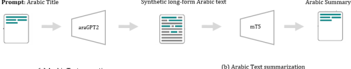


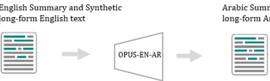

model,BEE,COI,TER,chr,spE
OPUS (or-big),86.7,79.0,4.1,13.9,14.4
NLB 600M,86.7,75.8,4.0,13.7,14.2
ChatGPT-3.5,90.5,66.6,60.7,25.8,25.7

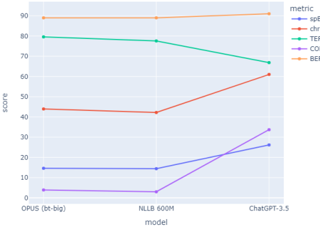

model,BERTScore,COMET,Human,TER,chrF,spBLEU
OPUS (st-big) FT,53.1,65.1,94.9,51.2,48.4,38.4
NLB 600M FT,52.1,54.5,93.7,60.9,43.6,51.8
ChatGPT-3.5 FT,56.5,46.4,93.7,71.2,51.3,51.1

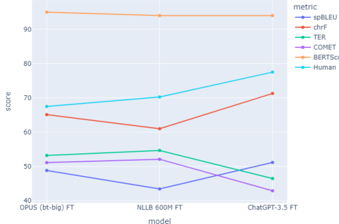

model,BERTScore,COMET,Human,TER,chrF,spBLEU
OPUS (bt-big) FT (back MT),65.6,54.8,73.2,55.1,64.7,47.7
OPUS (bt-big) FT (synthetic),59.6,50.0,66.7,60.2,58.2,40.2
NLLB 600M FT (back MT),52.6,52.9,66.5,58.3,60.8,42.2
NLLB 600M FT (Synthetic),59.5,58.3,72.7,58.2,58.5,40.5
ChatGPT-3.5 FT (back MT),55.2,64.6,92.5,55.6,66.5,44.4
ChatGPT-3.5 FT (synthetic),70.5,70.0,69.9,62.8,62.8,34.2

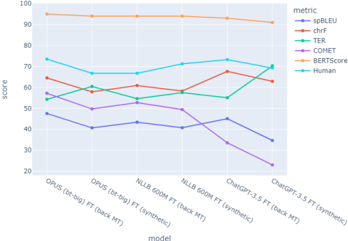

In [17]:
# Stage 3: Visualize Multiple Analysis Results
# For DATA_VISUALIZATION: Gemma + DePlot + ChartGemma (3 results)
# For CONCEPTUAL: Gemma + Web Search (2 results)

import json
from pathlib import Path
from IPython.display import display, HTML

from Functions.utils_logging import setup_basic_logging
from Functions.image_analysis import analyze_single_image_with_lmstudio

setup_basic_logging()

# Auto-detect the enhanced JSON from Stage 2 (prefer ChartGemma version if available)
# This will automatically use the latest enhanced JSON generated in Stage 2
import glob
import os

def find_latest_enhanced_json():
    """Find the most recent enhanced JSON file, preferring ChartGemma version"""
    # Try to get the enhanced_path from Stage 2 if it exists
    if 'enhanced_path' in globals() and enhanced_path and os.path.exists(enhanced_path):
        return enhanced_path
    
    # Otherwise, search for enhanced JSON files
    patterns = [
        "*_with_chartgemma.json",
        "*_with_descriptions_and_chart_data.json",
        "*_enhanced.json"
    ]
    
    latest_file = None
    latest_time = 0
    
    for pattern in patterns:
        files = glob.glob(pattern)
        for file in files:
            mtime = os.path.getmtime(file)
            if mtime > latest_time:
                latest_time = mtime
                latest_file = file
    
    return latest_file or r"C:\Users\Hongyu\OneDrive - Northwestern University\NU\Capstone\PDF_Analyzer_App\output\applsci-14-07088-v2_with_descriptions_and_chart_data.json"

SOURCE_JSON = find_latest_enhanced_json()
print(f"📂 Using enhanced JSON: {SOURCE_JSON}")

LM_STUDIO_URL = "http://localhost:1234/v1/chat/completions"
MODEL_NAME = "google/gemma-3-12b-it-gguf"

# Small HTML helpers

def html_escape(s: str) -> str:
    return (
        s.replace("&", "&amp;")
         .replace("<", "&lt;")
         .replace(">", "&gt;")
         .replace('"', "&quot;")
    )


def render_sources(sources: list[dict]) -> str:
    if not sources:
        return "<div style='color:#6b7280'>No sources</div>"
    items = []
    for i, src in enumerate(sources, 1):
        title = html_escape(src.get("title") or f"Source {i}")
        url = src.get("url") or ""
        body = html_escape(src.get("body") or "")
        link = f"<a href='{url}' target='_blank' rel='noopener noreferrer'>{title}</a>" if url else title
        items.append(f"<li style='margin:4px 0'>{link}<div style='color:#6b7280;font-size:12px'>{body}</div></li>")
    return "<ul style='margin:6px 0 0 18px;padding:0'>" + "".join(items) + "</ul>"


def render_chart_tables(cde: dict, max_rows: int = 12) -> str:
    if not isinstance(cde, dict):
        return "<div style='color:#6b7280'>No chart data</div>"

    tables_html = []
    datasets = cde.get("datasets") or {}
    x_categories = cde.get("x_categories")

    # Optional top summary
    insight = cde.get("chart_insight") or ""
    data_points = cde.get("data_points_count")
    chart_type = cde.get("chart_type") or ""
    x_label = cde.get("x_axis_label") or "X"
    y_labels = cde.get("y_axis_labels") or list(datasets.keys())

    summary_bits = []
    if data_points is not None:
        summary_bits.append(f"{int(data_points)} points")
    if cde.get("data_ranges", {}).get("x_range"):
        x_min, x_max = cde["data_ranges"]["x_range"]
        summary_bits.append(f"X in [{x_min}, {x_max}]")
    if chart_type:
        summary_bits.append(chart_type)

    summary = " | ".join(summary_bits)
    if summary:
        tables_html.append(f"<div style='color:#374151;margin:6px 0'><b>Chart data:</b> {html_escape(summary)}</div>")
    if insight:
        tables_html.append(f"<div style='color:#374151;margin:4px 0'>{html_escape(insight)}</div>")

    # Render one table per dataset
    if not datasets:
        # If we only have raw_table, show it collapsed
        raw_table = cde.get("raw_table")
        if raw_table:
            safe_raw = html_escape(raw_table)
            tables_html.append(
                """
                <details style='margin-top:6px'><summary>Raw DePlot output</summary>
                <pre style='white-space:pre-wrap;border:1px solid #e5e7eb;border-radius:6px;padding:8px;margin-top:6px'>""" + safe_raw + """</pre></details>
                """
            )
        return "".join(tables_html) or "<div style='color:#6b7280'>No structured datasets</div>"

    for series_name, points in datasets.items():
        series_label = html_escape(str(series_name))
        rows = points[:max_rows] if isinstance(points, list) else []
        # Build simple 2-column table (X, Y)
        thead = f"<thead><tr><th style='text-align:left;padding:6px;border-bottom:1px solid #e5e7eb'>{html_escape(x_label)}</th><th style='text-align:left;padding:6px;border-bottom:1px solid #e5e7eb'>{series_label}</th></tr></thead>"
        trs = []
        for x, y in rows:
            trs.append(
                f"<tr><td style='padding:6px;border-bottom:1px solid #f3f4f6'>{x}</td><td style='padding:6px;border-bottom:1px solid #f3f4f6'>{y}</td></tr>"
            )
        more = ""
        if isinstance(points, list) and len(points) > max_rows:
            more = f"<div style='color:#6b7280;font-size:12px;margin-top:4px'>(+{len(points)-max_rows} more rows)</div>"
        table_html = (
            f"<div style='margin-top:8px'><div style='font-weight:600;margin:4px 0'>{series_label}</div>"
            f"<table style='border-collapse:collapse;width:100%;border:1px solid #e5e7eb;border-radius:6px'>"
            f"{thead}<tbody>" + "".join(trs) + "</tbody></table>" + more + "</div>"
        )
        tables_html.append(table_html)

    # If categorical X is present, expose it
    if x_categories:
        safe_cats = html_escape(", ".join(map(str, x_categories)))
        tables_html.append(
            f"<div style='color:#6b7280;font-size:12px;margin-top:6px'>X categories: {safe_cats}</div>"
        )

    return "".join(tables_html)


# Load JSON and render
p = Path(str(SOURCE_JSON))
if not p.is_file():
    display(HTML(f"<div style='color:#b91c1c'>Source JSON not found: <code>{html_escape(SOURCE_JSON)}</code></div>"))
else:
    data = json.loads(p.read_text(encoding="utf-8"))
    pictures = data.get("pictures", [])
    display(HTML(f"<div style='margin:8px 0;color:#374151'>Loaded <b>{len(pictures)}</b> pictures from <code>{html_escape(p.name)}</code></div>"))

    for idx, pic in enumerate(pictures, start=1):
        ai = pic.get("ai_analysis", {}) or {}
        img_type = (ai.get("image_type") or "").upper()

        # Check for image presence - handle both Stage 1 (with images) and Stage 2 (NLP-ready, images removed)
        image_uri = (pic.get("image") or {}).get("uri", "")
        
        # Enhanced image detection: check for actual base64 data, not just placeholder
        has_image = (
            isinstance(image_uri, str) and 
            image_uri.startswith("data:image") and 
            "base64," in image_uri and 
            len(image_uri) > 100 and  # Substantial data, not just placeholder
            "REMOVED_FOR_NLP" not in image_uri
        )
        
        # Check if images were removed in Step 2
        images_removed = ai.get("images_removed_in_step2", False)

        # Description: prefer enriched, then base description
        desc = ai.get("enriched_description") or ai.get("description") or ""
        source = "stage2"

        # If missing or too short, try live analysis as fallback (kept minimal for diagnostics)
        if has_image and (not isinstance(desc, str) or len(desc.strip()) < 10):
            fresh = analyze_single_image_with_lmstudio(image_uri, LM_STUDIO_URL, MODEL_NAME, idx)
            if fresh and not fresh.get("is_non_informative"):
                desc = fresh.get("detailed_description", "") or desc
                source = "gemma_live"

        # Generate analysis sections based on image type
        analysis_sections = []
        
        if img_type == "CONCEPTUAL":
            # For CONCEPTUAL images: Show Gemma + Web Search
            
            # 1. Gemma Analysis
            analysis_sections.append(
                f"<div style='margin-top:12px;padding:12px;border:1px solid #1976d2;border-radius:6px'>"
                f"<div style='font-weight:600;margin-bottom:8px;color:#1976d2'>🤖 Gemma Analysis</div>"
                f"<div style='line-height:1.6'>{html_escape(desc).replace('\n','<br>') or '<span style=\"color:#888\">No description</span>'}</div>"
                f"</div>"
            )
            
            # 2. Web Search Results
            web_ctx = ai.get("web_context") or {}
            if web_ctx:
                summary = html_escape(web_ctx.get("ai_summary") or "")
                sources_html = render_sources(web_ctx.get("sources") or [])
                analysis_sections.append(
                    f"<div style='margin-top:12px;padding:12px;border:1px solid #2e7d2e;border-radius:6px'>"
                    f"<div style='font-weight:600;margin-bottom:8px;color:#2e7d2e'>🌐 Web Search Context</div>"
                    f"<div style='margin:4px 0;line-height:1.6'>{summary}</div>"
                    f"{sources_html}"
                    f"</div>"
                )
            else:
                analysis_sections.append(
                    f"<div style='margin-top:12px;padding:12px;border:1px solid #dc2626;border-radius:6px'>"
                    f"<div style='font-weight:600;margin-bottom:8px;color:#dc2626'>🌐 Web Search Context</div>"
                    f"<div style='color:#888'>No web search results available</div>"
                    f"</div>"
                )
        
        elif img_type == "DATA_VISUALIZATION":
            # For DATA_VISUALIZATION images: Show Gemma + DePlot + ChartGemma
            
            # 1. Gemma Analysis
            analysis_sections.append(
                f"<div style='margin-top:12px;padding:12px;border:1px solid #1976d2;border-radius:6px'>"
                f"<div style='font-weight:600;margin-bottom:8px;color:#1976d2'>🤖 Gemma Analysis</div>"
                f"<div style='line-height:1.6'>{html_escape(desc).replace('\n','<br>') or '<span style=\"color:#888\">No description</span>'}</div>"
                f"</div>"
            )
            
            # 2. DePlot Chart Data Extraction
            cde = ai.get("chart_data_extraction") or {}
            if ai.get("chart_insight") and not cde.get("chart_insight"):
                cde = dict(cde)
                cde["chart_insight"] = ai.get("chart_insight")
            
            datasets = cde.get("datasets") or {}
            if datasets:
                x_label = cde.get("x_axis_label") or "X"
                x_categories = cde.get("x_categories") or []
                
                # Build unified data structure: {x_index: {metric1: value1, metric2: value2, ...}}
                unified_data = {}
                all_metrics = set(datasets.keys())
                
                # Collect all data points and organize by X index (0, 1, 2 for the 3 models)
                for metric_name, points in datasets.items():
                    for x_idx, y_val in points:
                        x_key = int(x_idx)  # Use integer index as key
                        if x_key not in unified_data:
                            unified_data[x_key] = {}
                        unified_data[x_key][metric_name] = y_val
                
                # Sort X indices
                x_indices = sorted(unified_data.keys())
                
                # Create table header: X + all metrics (sorted for consistent order)
                metrics_list = sorted(all_metrics)
                header_cells = [f"<th style='text-align:left;padding:6px;border-bottom:1px solid #e5e7eb'>{html_escape(x_label)}</th>"]
                header_cells.extend([f"<th style='text-align:left;padding:6px;border-bottom:1px solid #e5e7eb'>{html_escape(str(m))}</th>" for m in metrics_list])
                header_html = "<thead><tr>" + "".join(header_cells) + "</tr></thead>"
                
                # Create table rows
                body_rows = []
                for x_idx in x_indices:
                    # X column: use category name if available (model names)
                    if x_categories and 0 <= x_idx < len(x_categories):
                        x_display = html_escape(str(x_categories[x_idx]))
                    else:
                        x_display = html_escape(str(x_idx))
                    
                    row_cells = [f"<td style='padding:6px;border-bottom:1px solid #f3f4f6;font-weight:500'>{x_display}</td>"]
                    
                    # Add cells for each metric
                    for metric in metrics_list:
                        value = unified_data[x_idx].get(metric, "")
                        value_str = str(value) if value != "" else "-"
                        row_cells.append(f"<td style='padding:6px;border-bottom:1px solid #f3f4f6;text-align:center'>{html_escape(value_str)}</td>")
                    
                    body_rows.append("<tr>" + "".join(row_cells) + "</tr>")
                
                # Add summary info
                insight = cde.get("chart_insight") or ""
                summary_text = ""
                if insight:
                    summary_text = f"<div style='margin:4px 0;font-size:12px;color:#666'>{html_escape(insight)}</div>"
                
                deplot_content = (
                    f"{summary_text}"
                    f"<table style='border-collapse:collapse;width:100%;border:1px solid #e5e7eb;border-radius:6px'>"
                    f"{header_html}<tbody>" + "".join(body_rows) + "</tbody></table>"
                )
            else:
                deplot_content = render_chart_tables(cde)
            
            analysis_sections.append(
                f"<div style='margin-top:12px;padding:12px;border:1px solid #f57c00;border-radius:6px'>"
                f"<div style='font-weight:600;margin-bottom:8px;color:#f57c00'>📊 DePlot Data Extraction</div>"
                f"{deplot_content}"
                f"</div>"
            )
            
            # 3. ChartGemma Analysis
            chartgemma_analysis = ai.get("chartgemma_analysis") or {}
            if chartgemma_analysis:
                if "error" in chartgemma_analysis:
                    chartgemma_content = f"<div style='color:#dc2626'>Error: {html_escape(chartgemma_analysis['error'])}</div>"
                else:
                    question = chartgemma_analysis.get("question", "")
                    response = chartgemma_analysis.get("response", "")
                    chart_type = chartgemma_analysis.get("chart_type_detected", "unknown")
                    
                    chartgemma_content = (
                        f"<div style='margin-bottom:8px;font-size:12px;color:#888'>Chart type: {html_escape(chart_type)}</div>"
                        f"<div style='margin-bottom:6px;font-style:italic;color:#aaa'>Question: {html_escape(question)}</div>"
                        f"<div style='line-height:1.6'>{html_escape(response).replace('\n','<br>')}</div>"
                    )
            else:
                chartgemma_content = "<div style='color:#888'>ChartGemma analysis not available</div>"
            
            analysis_sections.append(
                f"<div style='margin-top:12px;padding:12px;border:1px solid #7b1fa2;border-radius:6px'>"
                f"<div style='font-weight:600;margin-bottom:8px;color:#7b1fa2'>🎯 ChartGemma Analysis</div>"
                f"{chartgemma_content}"
                f"</div>"
            )
        
        else:
            # For other image types: Show only Gemma analysis
            analysis_sections.append(
                f"<div style='margin-top:12px;padding:12px;border:1px solid #1976d2;border-radius:6px'>"
                f"<div style='font-weight:600;margin-bottom:8px;color:#1976d2'>🤖 Gemma Analysis</div>"
                f"<div style='line-height:1.6'>{html_escape(desc).replace('\n','<br>') or '<span style=\"color:#888\">No description</span>'}</div>"
                f"</div>"
            )

        # Render card with multiple analysis results
        analysis_count = len(analysis_sections)
        analysis_info = ""
        if img_type == "DATA_VISUALIZATION":
            analysis_info = f" • {analysis_count} analyses: Gemma + DePlot + ChartGemma"
        elif img_type == "CONCEPTUAL":
            analysis_info = f" • {analysis_count} analyses: Gemma + Web Search"
        else:
            analysis_info = f" • {analysis_count} analysis: Gemma only"
        
        parts = [
            "<div style='border:1px solid #e5e7eb;border-radius:8px;padding:16px;margin:16px 0'>",
            f"<div style='font-weight:600;margin-bottom:4px'>📄 Picture {idx} <span style='color:#6b7280;font-size:12px'>(type: {html_escape(img_type or 'UNKNOWN')}{analysis_info})</span></div>",
        ]
        
        # Image display or removal notification
        if has_image:
            parts.append(f"<img src='{image_uri}' style='max-width:100%;height:auto;border:1px solid #e5e7eb;border-radius:4px;margin:8px 0 12px' />")
        elif images_removed:
            parts.append("<div style='margin:8px 0 12px;padding:8px;border:1px dashed #9ca3af;border-radius:4px;color:#6b7280;font-style:italic;text-align:center'>🗑️ Image data removed for NLP processing</div>")
        else:
            parts.append("<div style='margin:8px 0 12px;padding:8px;border:1px dashed #dc2626;border-radius:4px;color:#dc2626;font-style:italic;text-align:center'>⚠️ No image data found</div>")
        
        # Add all analysis sections
        for section in analysis_sections:
            parts.append(section)
        
        parts.append("</div>")
        display(HTML("".join(parts)))